# Assessment.ipynb
# Kai Fukami, UCLA MAE
# 2022/03/06

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Input, Add, Dense, Conv2D,Conv2DTranspose, MaxPooling2D, UpSampling2D, Flatten, Reshape, LSTM, Dropout, BatchNormalization
from keras.models import Model, Sequential
from keras.models import load_model
from keras import backend as K
from scipy.interpolate import griddata
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pickle
from keras import regularizers
from keras.utils import to_categorical

plt.rc('font',**{'family':'sans-serif','sans-serif':['Times New Roman']})
plt.rc('text', usetex=True)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rc('font', family='Times New Roman')

import tensorflow as tf
from keras.backend import tensorflow_backend
config = tf.ConfigProto(
    gpu_options=tf.GPUOptions(
        allow_growth=True,
        visible_device_list="3"
    )
)
session = tf.Session(config=config)
tensorflow_backend.set_session(session)

Using TensorFlow backend.
/home/fukami/.pyenv/versions/anaconda3-5.1.0/envs/kaif/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/fukami/.pyenv/versions/anaconda3-5.1.0/envs/kaif/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/fukami/.pyenv/versions/anaconda3-5.1.0/envs/kaif/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint1

In [2]:
!nvidia-smi

Mon Mar  7 15:10:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 390.30                 Driver Version: 390.30                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:1A:00.0 Off |                    0 |
| N/A   32C    P0    38W / 300W |     10MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:1B:00.0 Off |                    0 |
| N/A   34C    P0    38W / 300W |     10MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [3]:
## Loading the numpy arrays corresponding to the EEG dataset

X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Printing the shapes of the numpy arrays

print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [4]:
## Adjusting the labels to {0,1,2,3}

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

In [5]:
## Creating the training and validation sets

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(2115, 500, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

Shape of training set: (1615, 22, 1000)
Shape of validation set: (500, 22, 1000)
Shape of training labels: (1615,)
Shape of validation labels: (500,)
Shape of training labels after categorical conversion: (1615, 4)
Shape of validation labels after categorical conversion: (500, 4)
Shape of test labels after categorical conversion: (443, 4)
Shape of training set after adding width info: (1615, 22, 1000, 1)
Shape of validation set after adding width info: (500, 22, 1000, 1)
Shape of test set after adding width info: (443, 22, 1000, 1)
Shape of training set after dimension reshaping: (1615, 1000, 1, 22)
Shape of validation set after dimension reshaping: (500, 1000, 1, 22)
Shape of test set after dimension reshaping: (443, 1000, 1, 22)


## Load a trained model and history curve

In [4]:
from keras.models import load_model
model = load_model('./model_box/cnn_cv1.hdf5',custom_objects=None)
model.summary()

dr = pd.read_csv('./history_box/cnn_cv1.csv', header=None,delim_whitespace=None)
dataset = dr.values

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 1000, 1, 22)    0         
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 1, 1000, 1, 25)    23600     
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 1, 1000, 1, 25)    50100     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 1, 500, 1, 25)     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 500, 1, 25)     100       
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 500, 1, 25)     0         
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, 1, 500, 1, 50)     1502

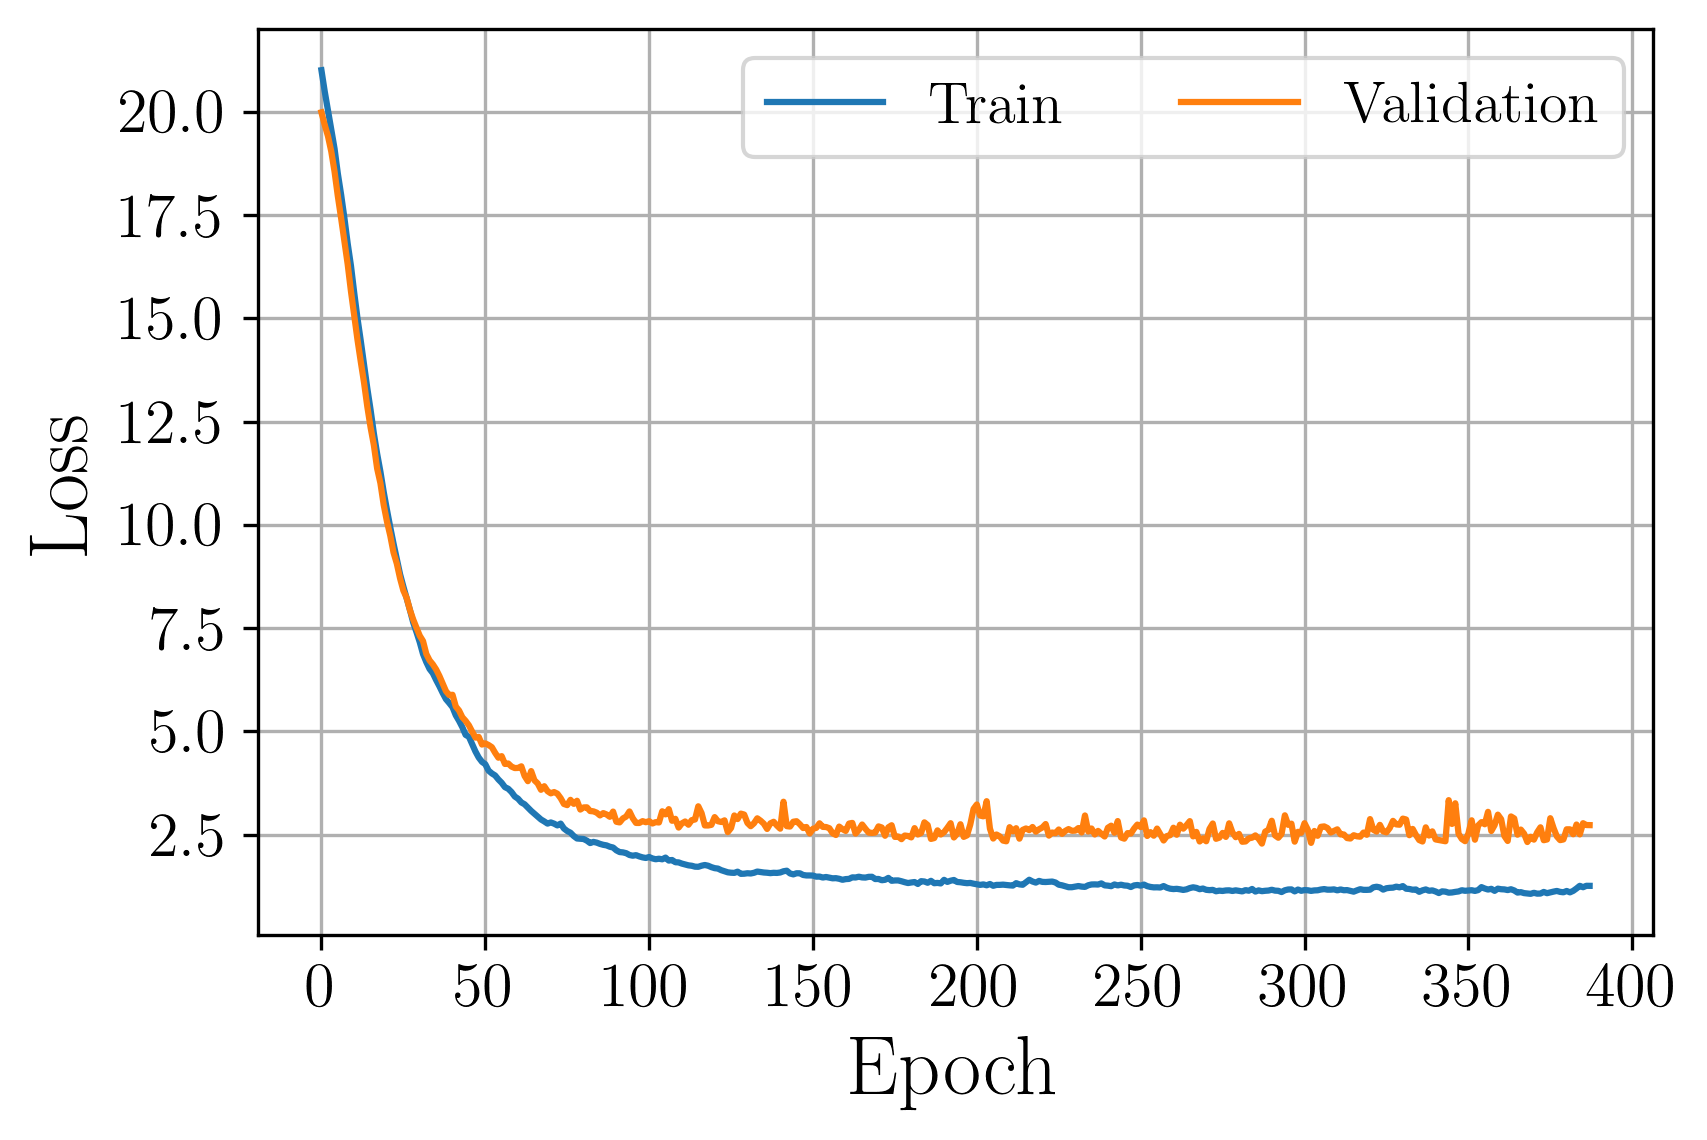

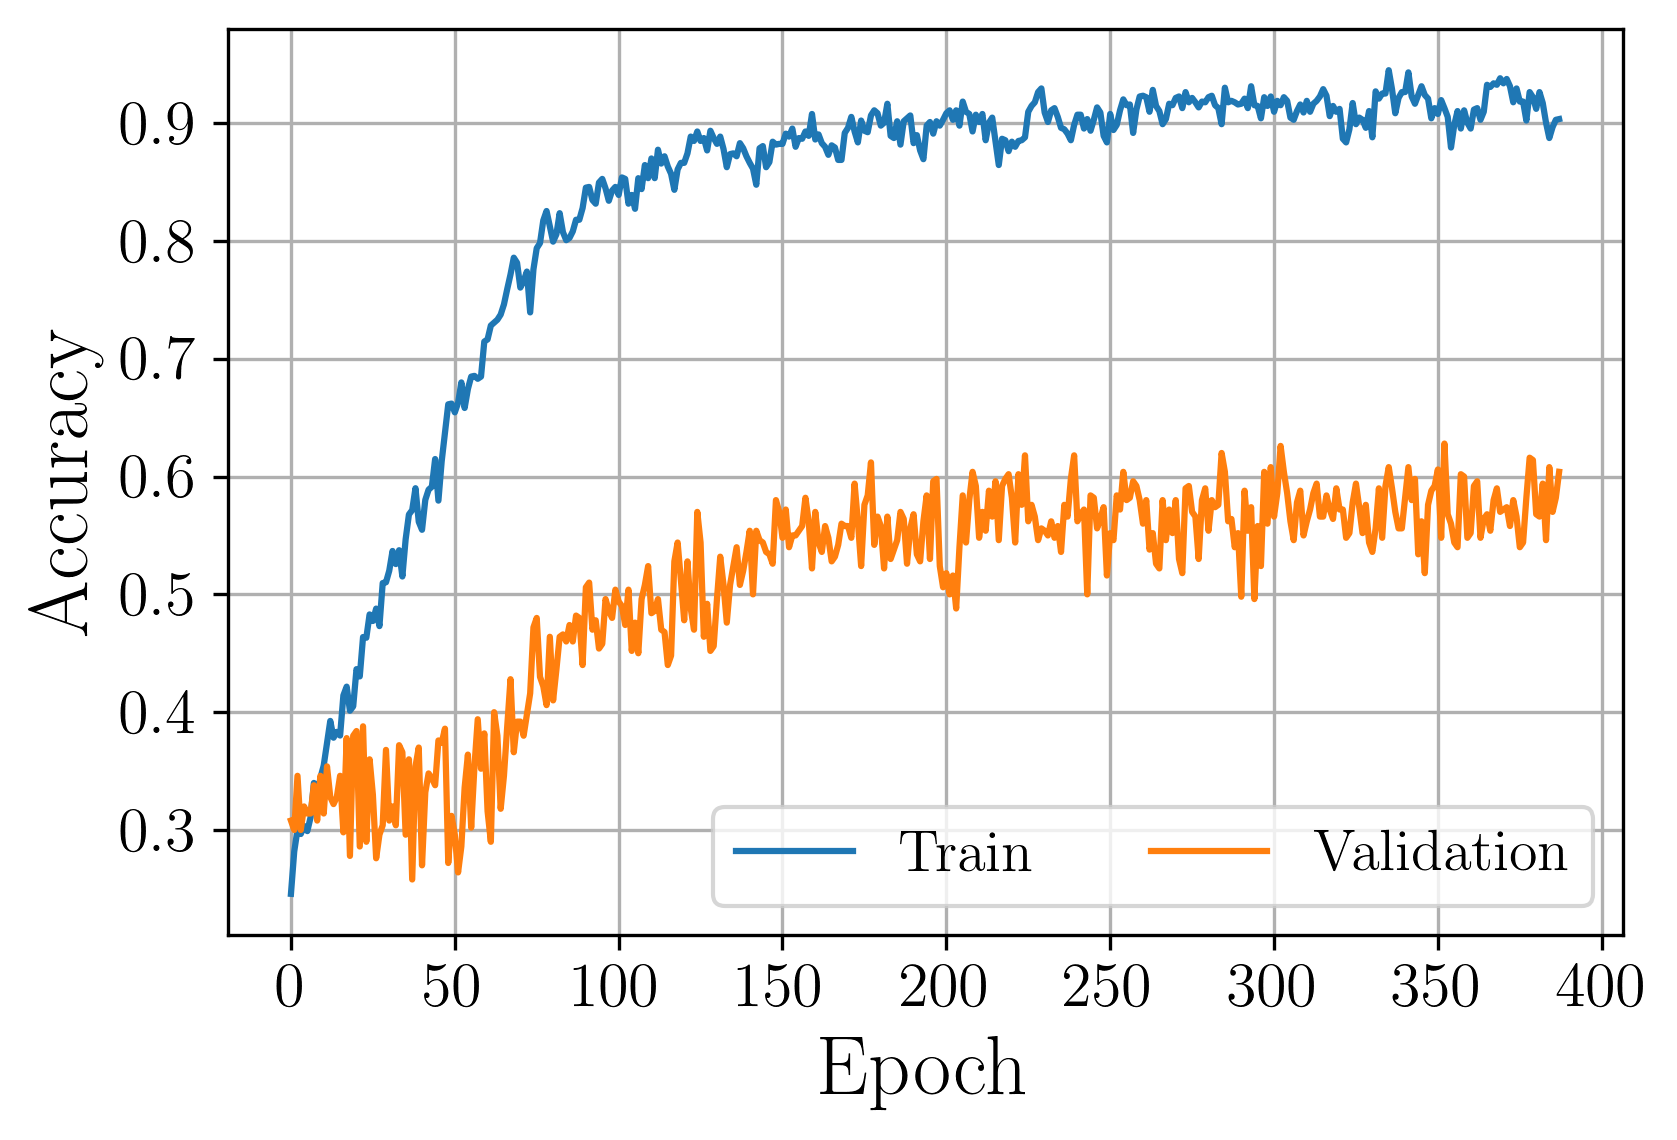

In [18]:
import matplotlib.pyplot as plt

X = dataset[:,:]
X1 = np.empty((len(dataset)-1,5))
X1[:,0] = X[1:len(dataset)+1,0]
X1[:,1] = X[1:len(dataset)+1,1]
X1[:,2] = X[1:len(dataset)+1,2]
X1[:,3] = X[1:len(dataset)+1,3]
X1[:,4] = X[1:len(dataset)+1,4]
fig = plt.figure(dpi=300)
plt.plot(X1[:,4],X1[:,2],label = 'Train')
plt.plot(X1[:,4],X1[:,0],label = 'Validation')
plt.xlabel("Epoch",fontsize=20)
plt.ylabel("Loss",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True)
plt.legend(ncol=2,fontsize=14)
plt.show()


fig = plt.figure(dpi=300)
plt.plot(X1[:,4],X1[:,3],label = 'Train')
plt.plot(X1[:,4],X1[:,1],label = 'Validation')
plt.xlabel("Epoch",fontsize=20)
plt.ylabel("Accuracy",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True)
plt.legend(ncol=2,fontsize=14)
plt.show()

In [19]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy',score[1])

Test accuracy 0.5891647854184997


In [7]:
# acc_box = [0.582,0.485,0.497,0.544,0.537]
# acc_box = [0.553,0.501,0.503,0.494,0.501]
# acc_box = [0.345,0.370,0.309,0.363,0.325]
# acc_box = [0.497,0.544,0.488,0.508,0.526]
# acc_box = [0.526,0.546,0.537,0.544,0.544]
# acc_box = [0.528,0.521,0.537,0.512,0.560]
acc_box = [0.499,0.501,0.524,0.508,0.515]
print(np.mean(acc_box))
print(np.std(acc_box))

0.5094000000000001
0.00922171350671881


In [17]:
num_t = np.array([200,400,600,800,1000])
err_avg = np.array([0.463,0.539,0.532,0.509,0.510])
std_box = np.array([0.0202,7.36e-3,0.0164,9.22e-3,0.0215])

In [18]:
err_m = err_avg-2*std_box
err_p = err_avg+2*std_box

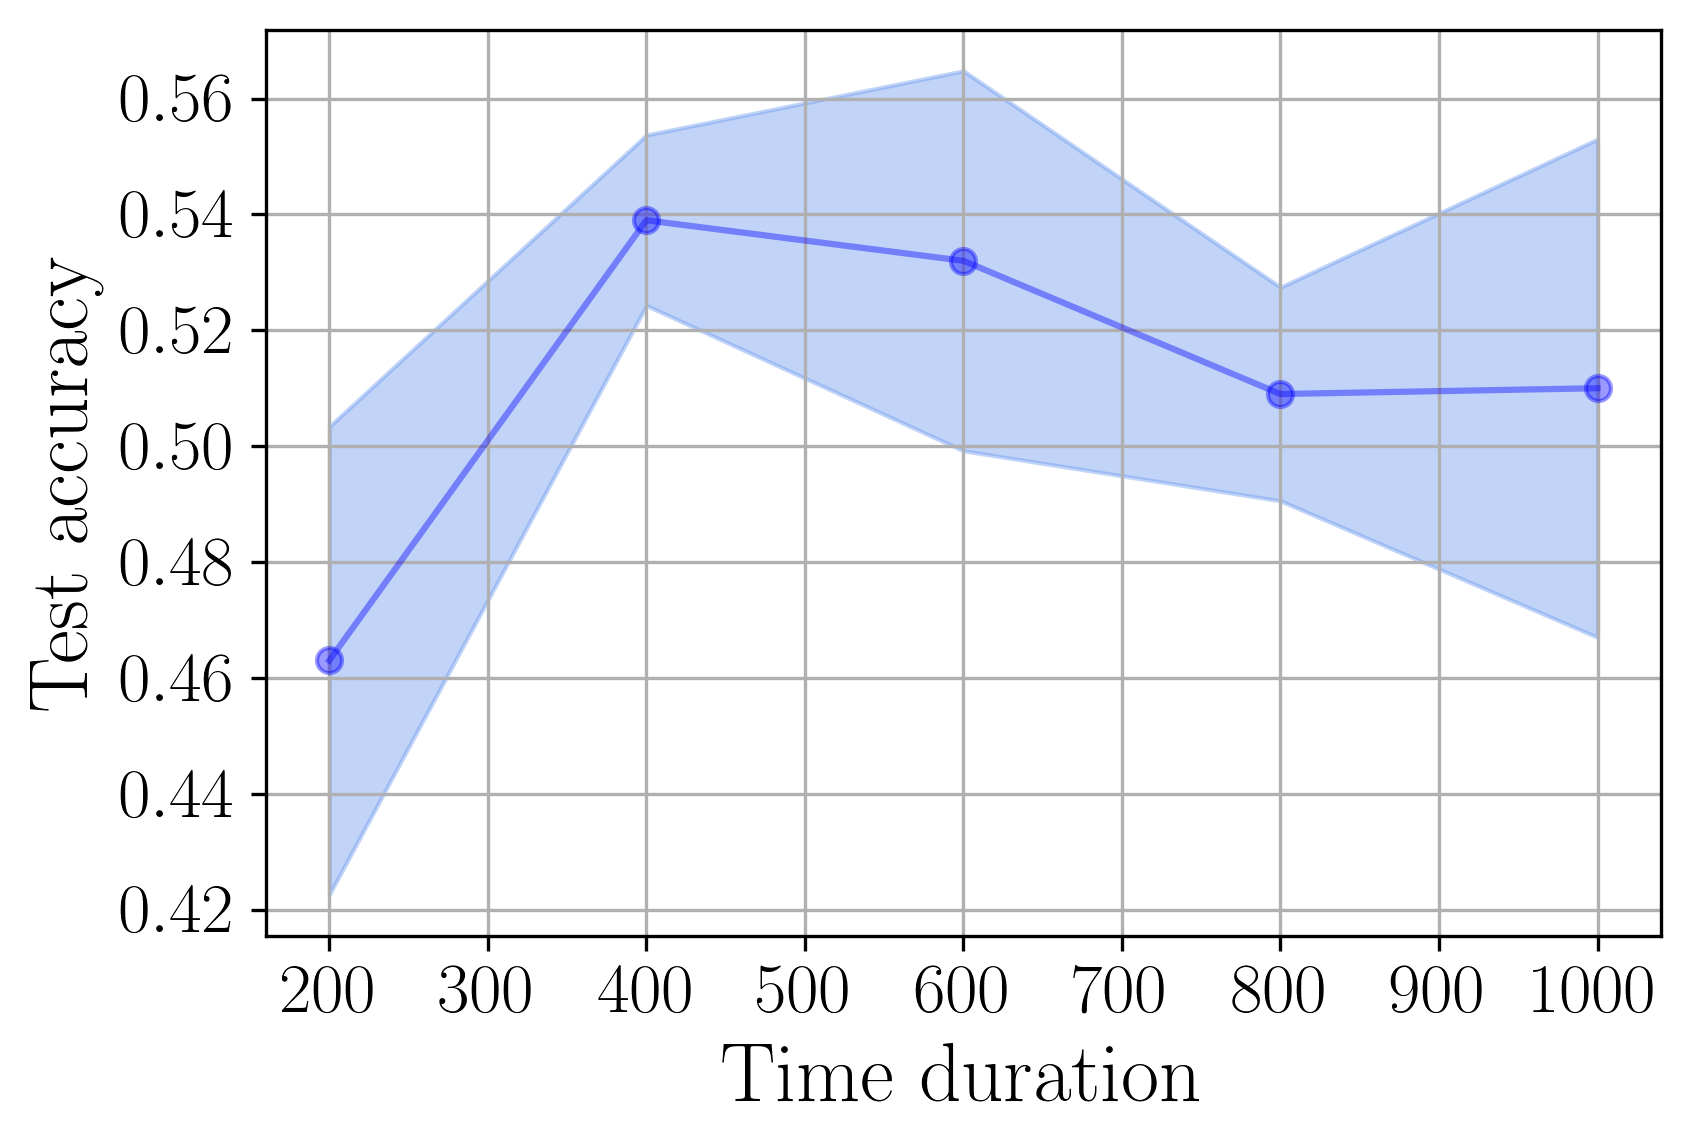

In [19]:
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

fig = plt.figure(dpi=300)
plt.plot(num_t,err_avg,linestyle='-',marker='o',color='blue',alpha=0.4)
plt.fill_between(num_t, err_m, err_p,color='cornflowerblue',alpha=0.4)



plt.grid()
plt.xticks(fontsize=17) #15 or 20
plt.yticks(fontsize=17) #15 or 20
#plt.xlabel(r'$\Delta Re_{\lambda}/n_{\rm snapshot}$',fontsize=20)
plt.ylabel(r'Test accuracy',fontsize=20) #20 or 30
plt.xlabel(r'Time duration',fontsize=20) # 20 or 30
#plt.ylabel(r'MSE',fontsize=30)
# plt.xscale('log')
#plt.yscale('log')

# plt.ylim((0.5,6.3))
plt.show()